# Classifier for CIFAR-10 dataset

## Import packages
Here we are using [Keras](https://github.com/keras-team/keras) with [TensorFlow](https://www.tensorflow.org/) to develop a **convolutional neural network (CNN)** classifier for the images in the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [ ]:
! nvidia-smi -L

GPU 0: Tesla P4 (UUID: GPU-55c6569d-f805-b741-c23b-6db592fb592d)


Importing required libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')


We explicitly define our CIFAR-10 image dimensions which will be used later to reshape our data.

In [ ]:
img_rows, img_cols = 32, 32

# Load data
Loading CIFAR-10 data from the Keras library itself and assigning it to training and test variables

In [ ]:
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = keras.datasets.cifar10.load_data()

# Data preprocessing 

In [ ]:
x_train = x_train_orig.reshape(x_train_orig.shape[0], img_rows, img_cols, 3)
x_test = x_test_orig.reshape(x_test_orig.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)

## Normalization
We also normalize the pixel values and convert class vectors to binary class matrices like we did previously.

In [ ]:
num_classes = 10
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


## Converting Training and Test output to Binary Class Matrix

In [ ]:
y_train = keras.utils.to_categorical(y_train_orig)
y_test = keras.utils.to_categorical(y_test_orig)

# Modelling

CNN Model - based on VGG
Using 3 VGG blocks followed by flatten and dense layers and a final softmax activation based dense layer which acts as a classifier


In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape, 
                                 use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.7))

# Classifier
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

# Optimizer
Using Adam optimizer with learning rate 0.001
Compiling the above defined model for *categorical_crossentropy* loss and *accuracy* metric

In [ ]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Data Augmentation using ImageDataGenerator()

Using ImageDataGenerator library of Keras, we are augmenting the training dataset with additional input samples.
datagen object is used to prepare the iterator based on the given batch size, here I have chosen bach_size of 16 based on earlier training runs



In [ ]:
from keras.preprocessing.image import ImageDataGenerator
#create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                             rotation_range=15, horizontal_flip=True)
batch_size = 16
#prepare iterator
it_train = datagen.flow(x_train, y_train, batch_size=batch_size)

# Training the model (Using Early Stopping)
Using **EarlyStopping** function of **callback** library in Keras to stop training when the validation_accuracy does not improve over a period of 30 epochs (as defined by patience argument of EarlyStopping function)

Otherwise, the model will train for 800 epochs

In [ ]:
#early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

#fit model
steps = int(np.ceil(x_train.shape[0] / batch_size))
model_log = model.fit(it_train, steps_per_epoch=steps, epochs=800, validation_data=(x_test, y_test), callbacks=[callback])

Epoch 1/800
3125/3125 [==============================] - 33s 11ms/step - loss: 1.8924 - accuracy: 0.3498 - val_loss: 1.2994 - val_accuracy: 0.5278
Epoch 2/800
3125/3125 [==============================] - 33s 11ms/step - loss: 1.3942 - accuracy: 0.5032 - val_loss: 1.0817 - val_accuracy: 0.6171
Epoch 3/800
3125/3125 [==============================] - 33s 10ms/step - loss: 1.2208 - accuracy: 0.5745 - val_loss: 0.9840 - val_accuracy: 0.6518
Epoch 4/800
3125/3125 [==============================] - 33s 10ms/step - loss: 1.0959 - accuracy: 0.6249 - val_loss: 1.0083 - val_accuracy: 0.6537
Epoch 5/800
3125/3125 [==============================] - 33s 11ms/step - loss: 1.0300 - accuracy: 0.6506 - val_loss: 0.8321 - val_accuracy: 0.7137
Epoch 6/800
3125/3125 [==============================] - 33s 11ms/step - loss: 0.9760 - accuracy: 0.6697 - val_loss: 0.7646 - val_accuracy: 0.7397
Epoch 7/800
3125/3125 [==============================] - 33s 11ms/step - loss: 0.9416 - accuracy: 0.6805 - val_loss: 0

# Plotting out the accuracy and loss
Below we plot out the trend of the accuracy and loss of both the training set and validation set.

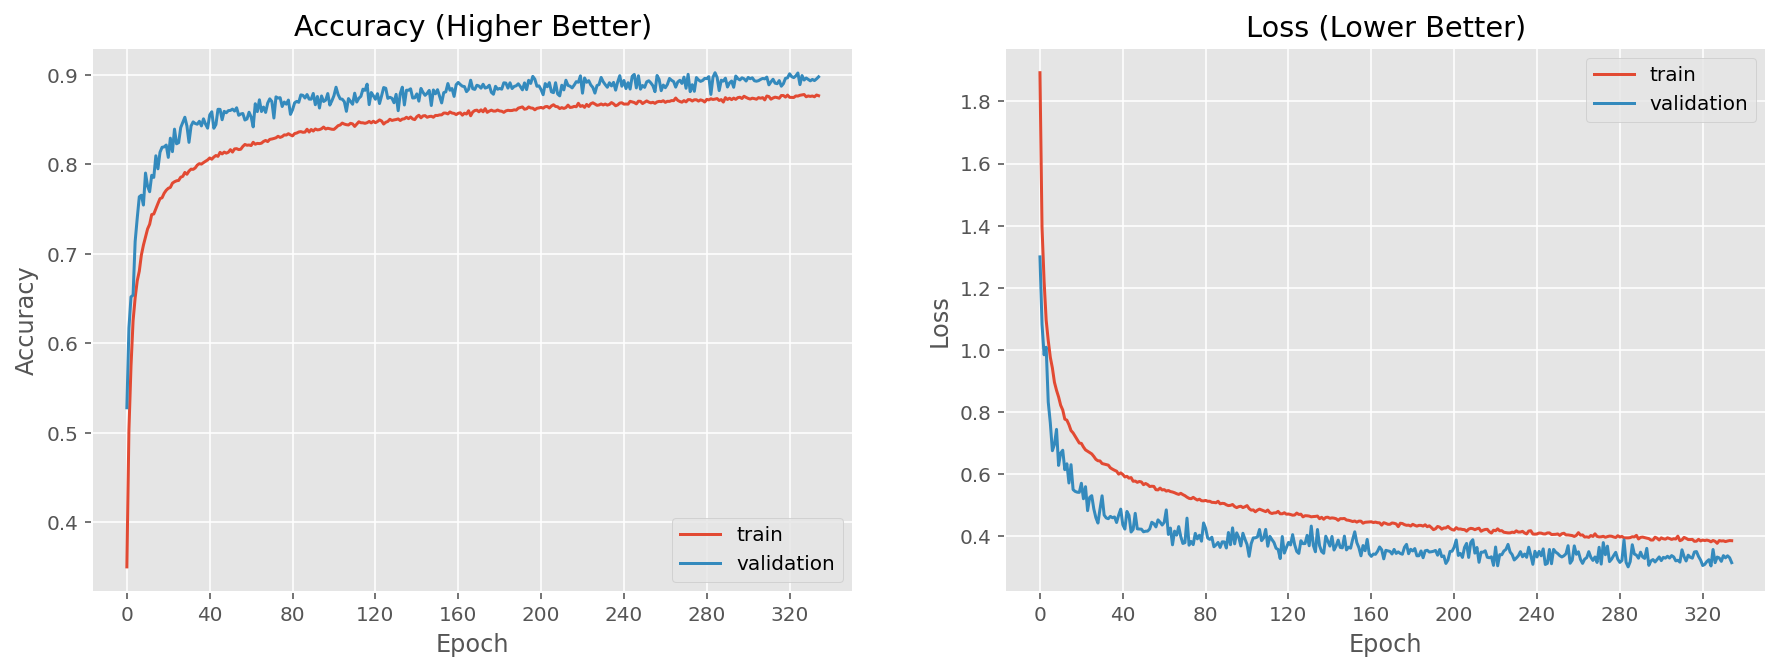

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.30097562074661255
Test accuracy: 0.9024999737739563


# Save the model

In [ ]:
model.save("Cifar-10_CNN")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Cifar-10_CNN/assets


# Testing the model
Testing the model against the test data to calculate probability of classification and the corresponding predictition

In [ ]:
y_pred_test = model.predict_proba(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

Instructions for updating:
Please use `model.predict()` instead.


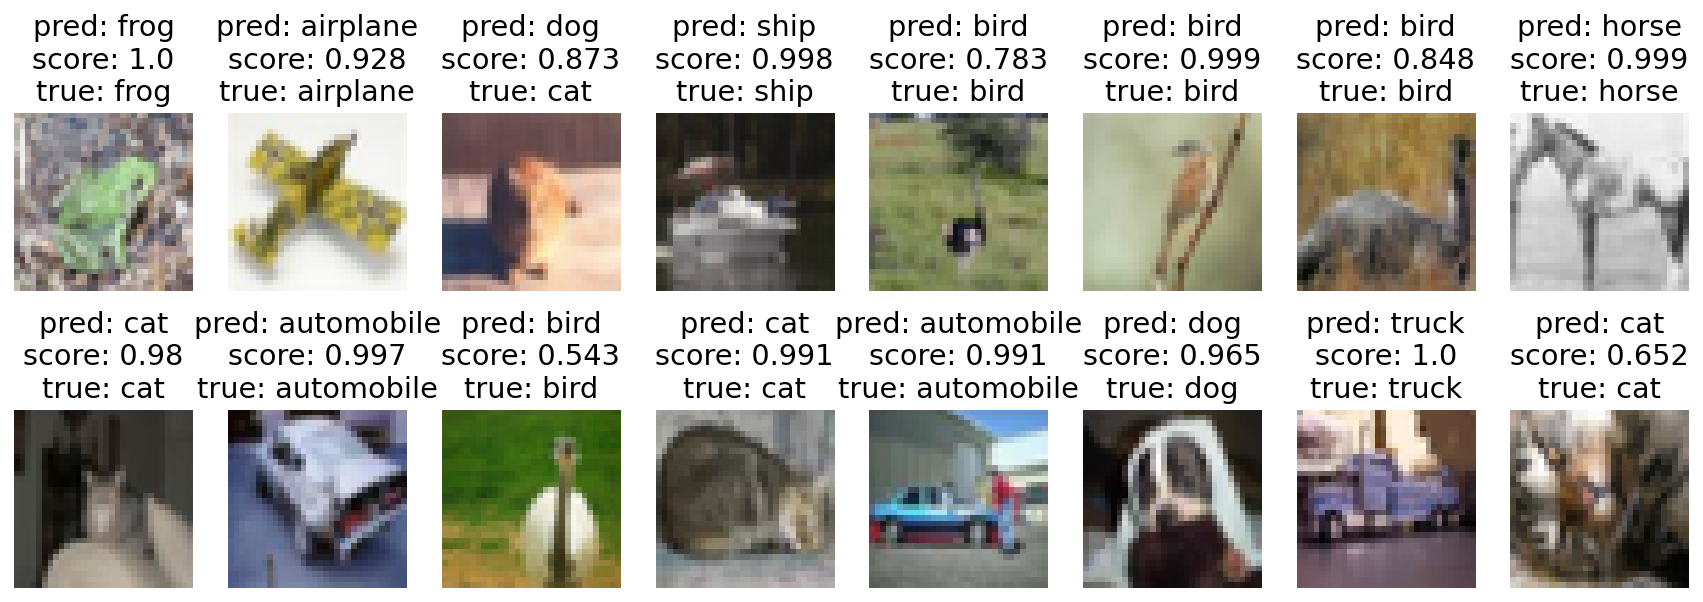

In [ ]:
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test_orig))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label =  cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_orig[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(pred_label, pred_proba, true_label))
plt.show()